In [1]:
!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/symptom2disease/Symptom2Disease.csv")
df = df.drop(["Unnamed: 0"], axis="columns")

# df['Aspect'] = df['Aspect'].astype(int)

df

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...
1196,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,diabetes,I regularly experience these intense urges and...
1198,diabetes,"I have trouble breathing, especially outside. ..."


In [3]:
df.isna().sum()

label    0
text     0
dtype: int64

In [4]:
df['label'].nunique()

24

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming your dataset is stored in a pandas DataFrame called df
# Extract the disease labels
disease_labels = df["label"].tolist()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the disease labels
encoded_labels = label_encoder.fit_transform(disease_labels)

# Print the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Add a new column with the encoded labels
df["disease_labels"] = encoded_labels

# Print the updated DataFrame
print("Updated DataFrame:")
df


Updated DataFrame:


,label,text,disease_labels
0,Psoriasis,I have been experiencing a skin rash on my arm...,15
1,Psoriasis,"My skin has been peeling, especially on my kne...",15
2,Psoriasis,I have been experiencing joint pain in my fing...,15
3,Psoriasis,"There is a silver like dusting on my skin, esp...",15
4,Psoriasis,"My nails have small dents or pits in them, and...",15
...,...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...,19
1196,diabetes,"Particularly in the crevices of my skin, I hav...",19
1197,diabetes,I regularly experience these intense urges and...,19
1198,diabetes,"I have trouble breathing, especially outside. ...",19


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


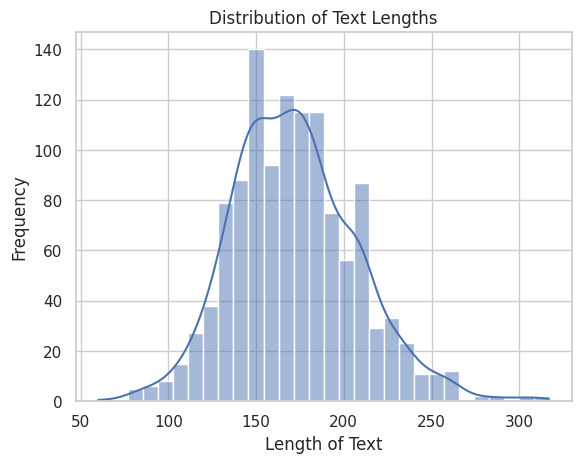

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Histogram of text lengths
sns.histplot(df['text'].apply(len), bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show() #give interpretation

### Inference
The histogram represents the distribution of text lengths in the dataset. Each bar on the
histogram corresponds to a range of text lengths, and the height of each bar indicates the frequency
of texts falling within that range
1. The majority of texts have a length between approximately 50 and 300 characters, as indicated by the tallest bars in the histogram.
2. There is a peak around 150 characters, suggesting that a significant portion of the texts are of moderate length.
3. The histogram tails off as text length increases beyond 1000 characters, indicating fewer texts with longer lengths.

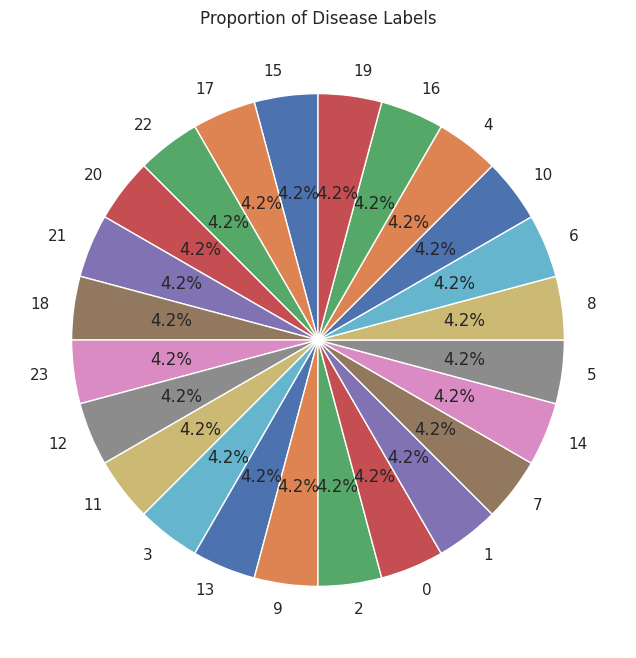

In [9]:
# Pie chart of disease labels
plt.figure(figsize=(8, 8))
df['disease_labels'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Disease Labels')
plt.ylabel('')
plt.show() 

### Inference
The pie chart illustrates the proportion of different disease labels within the dataset. Each
slice of the pie represents a disease label, and the size of each slice corresponds to the proportion
of texts associated with that particular disease label.
1. The pie chart provides a visual representation of the distribution of disease labels in the dataset.
2. It indicates that all diseaselabels have same number of text present
3. By observing the proportions, we can identify which disease labels are more common and which are less common within the dataset.
4. This information can be valuable for understanding the composition of the dataset and may influence the focus of analysis or the development of the healthcare chatbot.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


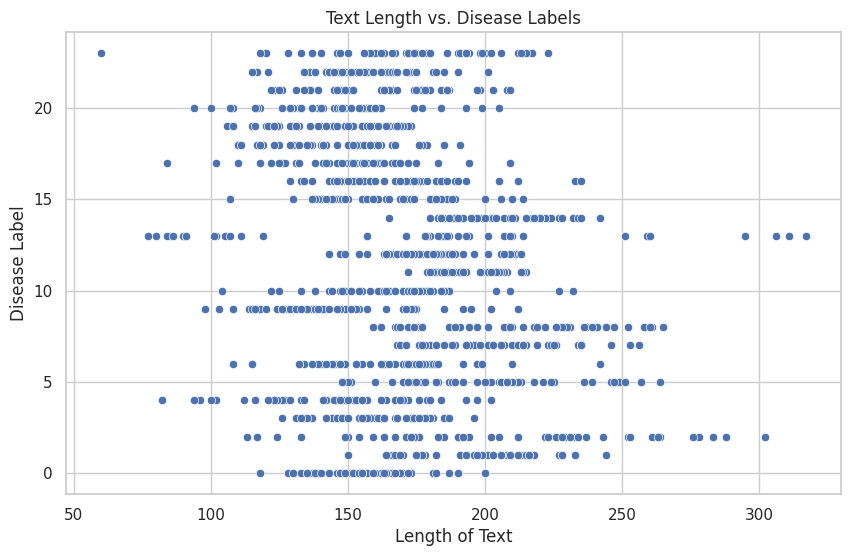

In [10]:
# Scatter plot of text length vs. disease labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['text'].apply(len), y=df['disease_labels'])
plt.title('Text Length vs. Disease Labels')
plt.xlabel('Length of Text')
plt.ylabel('Disease Label')
plt.show()

### Inference
The scatter plot visualizes the relationship between the length of texts and their corresponding
disease labels. Each point on the plot represents a text sample, with its position determined by the
length of the text on the x-axis and the disease label on the y-axis.
1. The scatter plot shows the distribution of text lengths across different disease labels.
2. There doesn’t appear to be a clear pattern or correlation between text length and disease label. The points are scattered across the plot, indicating that text length alone may not be a strong predictor of disease label.
3. However, there may be some clusters or trends within specific ranges of text lengths or disease labels, which could be explored further.
4. This visualization provides insight into the distribution of text lengths within each disease label category and can help identify any potential patterns or outliers in the dataset.

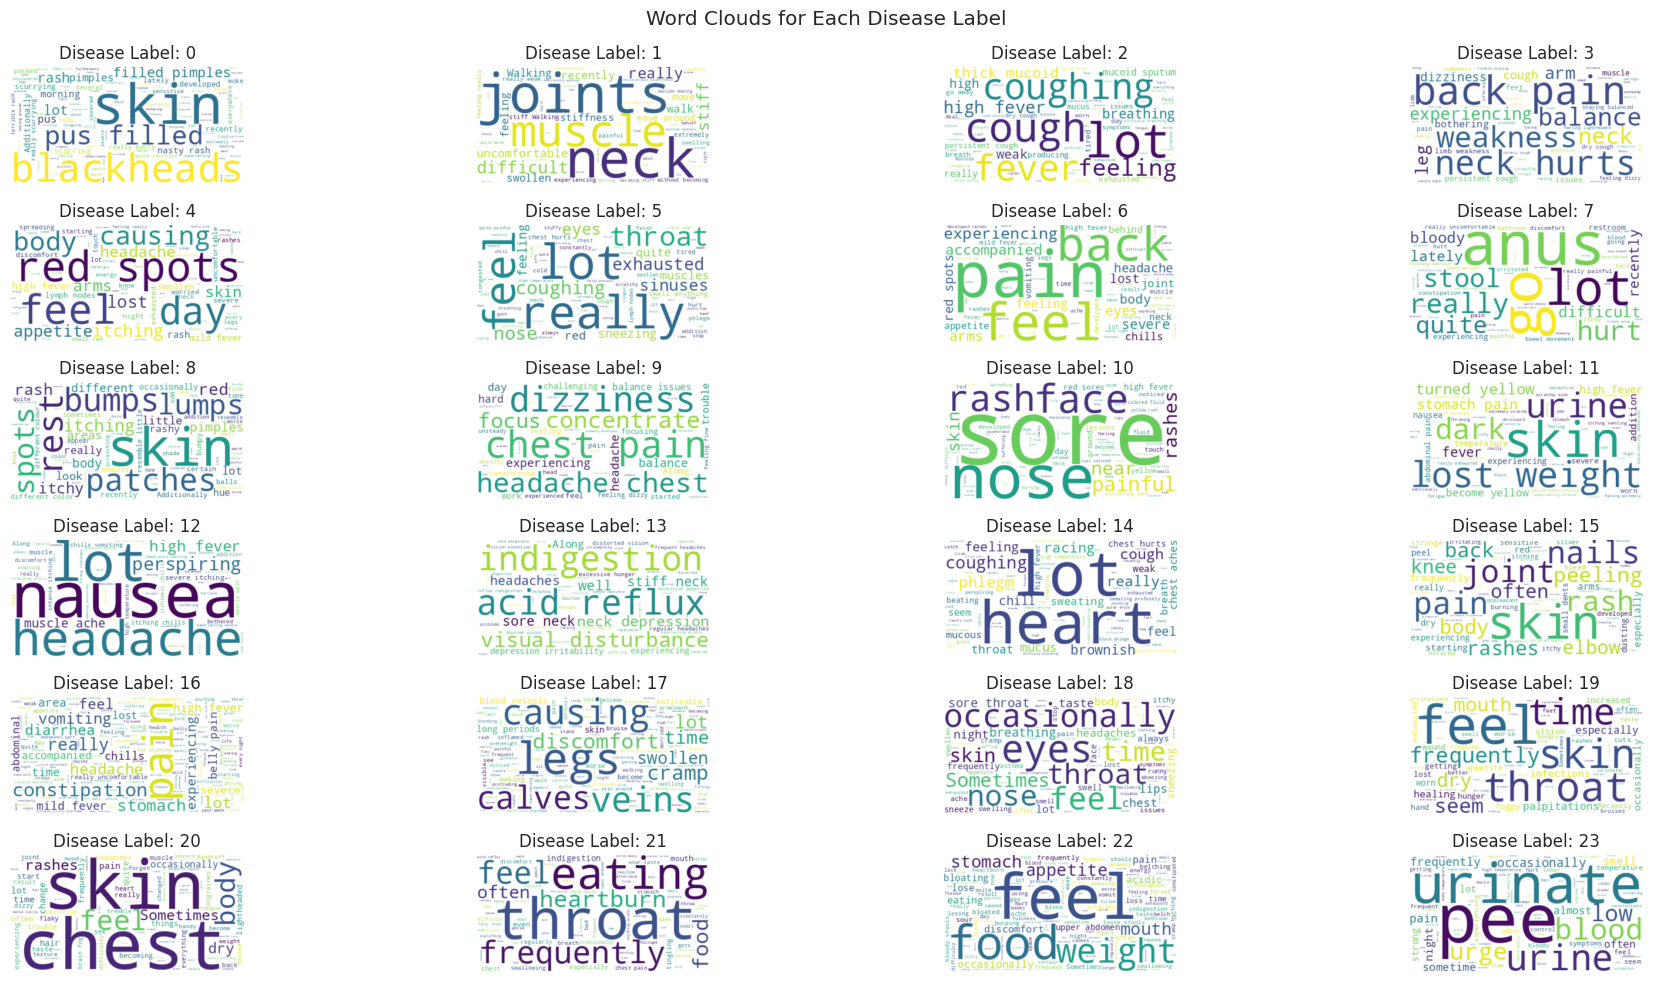

In [11]:
from wordcloud import WordCloud

# Concatenate text data for each disease label
text_by_label = df.groupby('disease_labels')['text'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(20, 10))
for i, (label, text) in enumerate(text_by_label.items(), 1):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    plt.subplot(6, 4, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Disease Label: {label}')
    plt.axis('off')
plt.suptitle('Word Clouds for Each Disease Label')
plt.tight_layout()
plt.show()



### Inference
1. Each subplot represents a word cloud for a specific disease label, with the title indicating the corresponding label.
2. The size of each word in the word cloud corresponds to its frequency in the texts associated with the disease label.
3. Words that appear larger are more prevalent in the texts, while smaller words are less common.
4. Analyzing the word clouds can provide insights into the prominent symptoms, characteristics, or concerns related to each disease, helping to understand the textual data more comprehensively.
5. Patterns or recurring terms within the word clouds may indicate common themes or topics associated with different diseases, which could be useful for further analysis or model development in the healthcare chatbot.

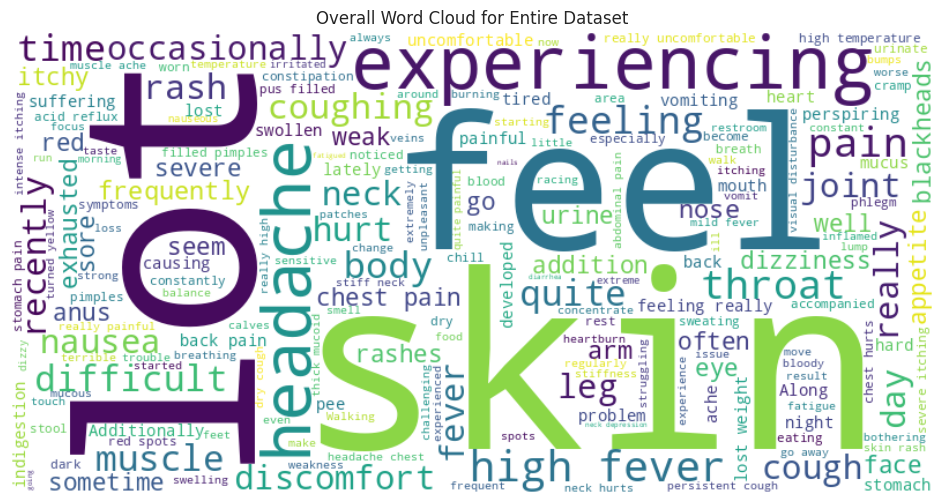

In [12]:
from wordcloud import WordCloud

# Concatenate all text data
all_text = ' '.join(df['text'])

# Generate word cloud for all text data
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Overall Word Cloud for Entire Dataset')
plt.axis('off')
plt.show()

### Inference
1. The word cloud displays words with varying sizes, where larger words indicate higher frequency and smaller words represent lower frequency.
2. Common terms that appear frequently across the dataset are emphasized and displayed prominently in the word cloud. (skin, lot, feel, experiencing)
3. By examining the word cloud, we can identify key terms or topics that are prevalent in the entire dataset, irrespective of specific disease labels.
4. This visualization helps in gaining insights into the general content and themes present in the dataset, enabling a better understanding of the overall textual data and guiding subsequent analysis or model development for the healthcare chatbot.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


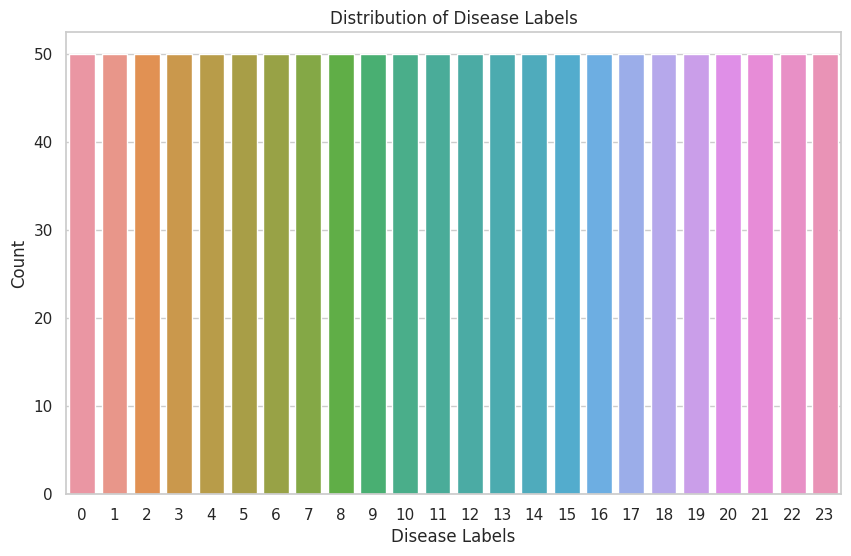

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of disease labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='disease_labels')
plt.title('Distribution of Disease Labels')
plt.xlabel('Disease Labels')
plt.ylabel('Count')
plt.show()

### Inference
1. The count plot provides an overview of the distribution of disease labels within the dataset.
2. Each disease label is represented on the x-axis, and the corresponding count of texts associated with that label is displayed on the y-axis. (equal counts are represented)
3. By observing the heights of the bars, we can quickly identify which disease labels are more prevalent or less prevalent in the dataset.
4. This visualization helps in understanding the composition of the dataset and the relative frequency of different disease labels, which is essential for analyzing and interpreting the textual data effectively.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


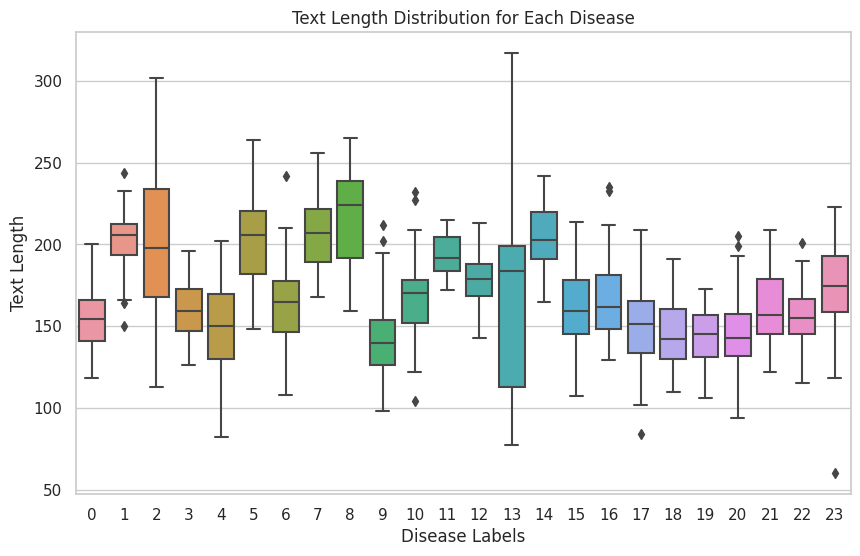

In [14]:
# Calculate the length of text for each row
df['text_length'] = df['text'].apply(len)

# Visualize the distribution of text length for each disease
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='disease_labels', y='text_length')
plt.title('Text Length Distribution for Each Disease')
plt.xlabel('Disease Labels')
plt.ylabel('Text Length')
plt.show()


### Inference
1. Each box plot represents the distribution of text lengths associated with a particular disease label.
2. The box in each plot indicates the interquartile range (IQR) of text lengths, with the line inside the box representing the median text length.
3. The whiskers extend to 1.5 times the IQR above and below the upper and lower quartiles, respectively, and any data points beyond the whiskers are considered outliers.
4. labels- 1,6,9,10,16,17,20,22,23 outliers are present
5. By comparing the box plots for different disease labels, we can observe variations in text length distributions across the diseases.
6. This visualization helps in understanding the range and distribution of text lengths within each disease category, providing insights into the textual characteristics associated with different diseases in the dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


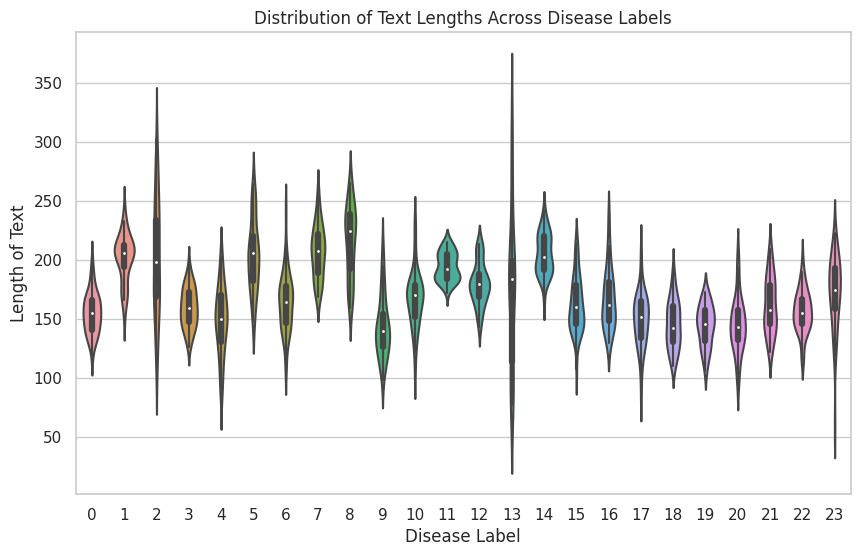

In [15]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['disease_labels'], y=df['text'].apply(len))
plt.title('Distribution of Text Lengths Across Disease Labels')
plt.xlabel('Disease Label')
plt.ylabel('Length of Text')
plt.show()

### Inference
1. Each violin plot represents the distribution of text lengths for a specific disease label.
2. he width of the violin plot at any given point indicates the density of text lengths at that value. Wider sections indicate a higher density of text lengths, while narrower sections indicate lower density. labels 0, 1 has higher density and 2,13 has lower density.
3. The central dot in each violin plot represents the median text length.
4. The shape of the violin plot shows the distribution of text lengths, with the broader sections  indicating a higher concentration of text lengths in that range.
5. By comparing the violin plots for different disease labels, we can observe variations in the distribution of text lengths across diseases.
6. This visualization provides insights into the spread and variability of text lengths within each disease category, helping to understand the textual characteristics associated with different diseases in the dataset.

In [16]:
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# Initialize XLM-RoBERTa tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Function to generate input data for XLM-RoBERTa
def generate_training_data(df, tokenizer):
    input_ids = []
    attention_masks = []

    for text in tqdm(df['text']):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        input_ids.append(tokenized_text.input_ids)
        attention_masks.append(tokenized_text.attention_mask)

    return np.vstack(input_ids), np.vstack(attention_masks)

X_input_ids, X_attn_masks = generate_training_data(df, tokenizer)

labels = np.zeros((len(df), 24))
labels[np.arange(len(df)), df['disease_labels'].values] = 1  # One-hot encoded target tensor

# Creating a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

# Function to map dataset
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

dataset = dataset.map(SentimentDatasetMapFunction)

dataset = dataset.shuffle(10000).batch(10, drop_remainder=True)

# Splitting the dataset into train and validation sets
p = 0.8
train_size = int((len(df) // 10) * p)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Load XLM-RoBERTa model
model = TFXLMRobertaModel.from_pretrained('xlm-roberta-base')

# Define model layers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

roberta_output = model(input_ids, attention_mask=attn_masks)[0]
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(roberta_output)
output_layer = tf.keras.layers.Dense(24, activation='softmax')(pooled_output)

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)


100%|██████████| 1200/1200 [00:01<00:00, 898.20it/s] 


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [17]:


# # Initialize RoBERTa tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # Function to generate input data for RoBERTa
# def generate_training_data(df, tokenizer):
#     input_ids = []
#     attention_masks = []

#     for text in tqdm(df['text']):
#         tokenized_text = tokenizer.encode_plus(
#             text,
#             max_length=256,
#             truncation=True,
#             padding='max_length',
#             add_special_tokens=True,
#             return_tensors='tf'
#         )
#         input_ids.append(tokenized_text.input_ids)
#         attention_masks.append(tokenized_text.attention_mask)

#     return np.vstack(input_ids), np.vstack(attention_masks)

# X_input_ids, X_attn_masks = generate_training_data(df, tokenizer)

# labels = np.zeros((len(df), 24))
# labels[np.arange(len(df)), df['disease_labels'].values] = 1  # One-hot encoded target tensor

# # Creating a TensorFlow dataset
# dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

# # Function to map dataset
# def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
#     return {
#         'input_ids': input_ids,
#         'attention_mask': attn_masks
#     }, labels

# dataset = dataset.map(SentimentDatasetMapFunction)

# dataset = dataset.shuffle(10000).batch(10, drop_remainder=True)

# # Splitting the dataset into train and validation sets
# p = 0.8
# train_size = int((len(df) // 10) * p)
# train_dataset = dataset.take(train_size)
# val_dataset = dataset.skip(train_size)

# # Load RoBERTa model
# model = TFRobertaModel.from_pretrained('roberta-base')

# # Define model layers
# input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
# attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

# roberta_output = model(input_ids, attention_mask=attn_masks)[0]
# pooled_output = tf.keras.layers.GlobalAveragePooling1D()(roberta_output)
# output_layer = tf.keras.layers.Dense(24, activation='softmax')(pooled_output)

# sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

In [18]:
# Compile the model
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

# Train the model
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4
)

Epoch 1/4
96/96 [==============================] - 53s 425ms/step - loss: 2.8903 - accuracy: 0.2094 - val_loss: 1.5253 - val_accuracy: 0.6833
Epoch 2/4
96/96 [==============================] - 39s 403ms/step - loss: 1.0210 - accuracy: 0.8000 - val_loss: 0.3184 - val_accuracy: 0.9375
Epoch 3/4
96/96 [==============================] - 39s 402ms/step - loss: 0.3375 - accuracy: 0.9375 - val_loss: 0.1232 - val_accuracy: 0.9625
Epoch 4/4
96/96 [==============================] - 39s 403ms/step - loss: 0.1578 - accuracy: 0.9740 - val_loss: 0.0310 - val_accuracy: 1.0000


In [19]:
df.label[df['disease_labels']==24]

Series([], Name: label, dtype: object)

In [20]:
# # Save the trained model
# # sentiment_model.save('sentiment_roberta_model')
# import pickle

# # Assuming your model object is named 'model'
# with open('sentiment_model.pkl', 'wb') as file:
#     pickle.dump(model, file)
# Save the model
# tf.saved_model.save(sentiment_model, 'sentiment_model')
# import shutil
# # Compress the folder into a ZIP file
# shutil.make_archive('sentiment_model', 'zip', 'sentiment_model')


# # Loading the saved model for prediction
# sentiment_model = tf.keras.models.load_model('sentiment_roberta_model')

# Function to prepare input data for prediction
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

# Function to make predictions
def make_prediction(model, processed_data, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]):
    probs = model.predict(processed_data)[0]
    predicted_label= classes[np.argmax(probs)]
    predicted_disease_name = df[df['disease_labels'] == predicted_label]['label'].iloc[0]
    
    return f"Hi, thank you for providing me with the symptoms. After analyzing your symptoms, the predicted disease is: {predicted_disease_name}"

# User input for prediction
# input_text = input('Enter your comment here: ')
# processed_data = prepare_data(input_text, tokenizer)
# result = make_prediction(sentiment_model, processed_data=processed_data)
# print(f"Predicted Aspect: {result}")

In [21]:
from py4j.java_gateway import JavaGateway
# Start the Py4J gateway server
gateway = JavaGateway()

# Register the Python functions with the gateway server
gateway.entry_point.prepareData = prepare_data
gateway.entry_point.makePrediction = make_prediction

# Call the prepareData function via Py4J gateway
# input_text = input('Enter your comment here: ')
# processed_data = gateway.entry_point.prepareData(input_text, tokenizer)
# result = make_prediction(sentiment_model, processed_data=processed_data)
# print(f"Predicted Aspect: {result}")

In [22]:
import ipywidgets as widgets
from IPython.display import display, HTML
import time

# Create input box and send button with custom CSS styles
input_box = widgets.Text(placeholder='Type here...')
input_box.add_class('input-box')
send_button = widgets.Button(description='Send', button_style='warning')  # Change button style to 'warning' for orange color
send_button.add_class('send-button')

# Apply CSS styles to the output box
output_box = widgets.Output()
output_box.add_class('output-box')

# Define CSS styles
css = """
<style>
.input-box {
    width: 70%;
    background: radial-gradient(circle, #f2d9fa, #e4bcf7);
    border: 5px solid #f5ebfa;
    box-shadow: 2px 2px 5px #ccc;
    padding: 5px;
}

.send-button {
    width: 30%;
    height:50%;
    background: radial-gradient(circle, #fc51b5, #f4d2fc);  /* Set button background color to orange */
    color: white;
    border: none;
    box-shadow: 2px 2px 5px #888;
    padding: 5px;
}

.output-box {
    background: radial-gradient(circle, #f2d9fa, #e4bcf7);
    border: 5px solid #f5ebfa;
    box-shadow: 2px 2px 5px #ccc;
    padding: 10px;
    font-weight: 600;
    font-size: 0.2rem;
    font-color: orange;
    font-family: system-ui;
    max-height: 300px;
    overflow-y: scroll;
}
</style>
"""

# Function to handle user input
def on_send_button_clicked(b):
    user_input = input_box.value.strip().lower()
    user_text = f"<span style='color: blue;'>User:</span> {user_input}<br>"
    bot_text = ""
    if user_input == 'hi':
        bot_text = "Bot: Hello, enter your symptoms."
        input_box.value = ''
    elif user_input == 'bye':
        bot_text = "Bot: Thank you for using the app. Goodbye!"
        input_box.disabled = True
        send_button.disabled = True
    else:
        processed_data = prepare_data(user_input, tokenizer)
        result = make_prediction(sentiment_model, processed_data=processed_data)
        bot_text = f"Bot: {result}"
        input_box.value = ''

    with output_box:
        display(HTML(user_text))  # Display user input as HTML
        for letter in bot_text:
            print(letter, end='', flush=True)
            time.sleep(0.05)  # Adjust typing speed here
        print()  # Add newline after completing bot text

# Link button click event to handler function
send_button.on_click(on_send_button_clicked)

# Display chat interface
display(HTML(css))
display(output_box)
display(widgets.HBox([input_box, send_button]))


Output(_dom_classes=('output-box',))